#### Acknowledgement
**In this notebook, GPT-4o is used to help debug code and prettify visualisations.**

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
from shapely.geometry import MultiPoint, Point, MultiLineString, LineString, MultiPolygon, Polygon

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import contextily as ctx
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import pysal.lib as ps
from scipy.spatial import cKDTree
from libpysal.weights import DistanceBand
from esda.getisord import G_Local
from esda.moran import Moran, Moran_BV, Moran_Local_BV

# WGMS

## 1. GLACIER
General (and presumably static) information about each glacier

In [2]:
glacier = pd.read_csv("data/wgms/glacier.csv")

glacier_nz = glacier[glacier["POLITICAL_UNIT"] == "NZ"]

glacier_nz_drop = glacier_nz.drop(["POLITICAL_UNIT", "REMARKS", "GLACIER_REGION_CODE", "GLACIER_SUBREGION_CODE",
                                  "GEN_LOCATION", "SPEC_LOCATION", "PARENT_GLACIER",
                                  "PRIM_CLASSIFIC", "FORM", "FRONTAL_CHARS", "EXPOS_ACC_AREA", "EXPOS_ABL_AREA"], axis=1)
glacier_nz_drop.head()

C:\Users\Zach\AppData\Local\Temp\ipykernel_12912\3864064715.py:1: DtypeWarning: Columns (3,4,10,11,13) have mixed types. Specify dtype option on import or set low_memory=False.
  glacier = pd.read_csv("data/wgms/glacier.csv")


,NAME,WGMS_ID,LATITUDE,LONGITUDE
158448,ABEL,1546,-43.320000,170.630005
158449,ADAMS,2923,-43.320000,170.720001
158450,AILSA,2924,-44.786100,168.187000
158451,ALMER/SALISBURY,1548,-43.470001,170.220001
158452,ANDY,1590,-44.430000,168.369995


In [3]:
glacier_nz_drop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2869 entries, 158448 to 161316
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   NAME       2869 non-null   object 
 1   WGMS_ID    2869 non-null   int64  
 2   LATITUDE   2869 non-null   float64
 3   LONGITUDE  2869 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 112.1+ KB


## 2. CHANGE
Change in glacier thickness, area, and/or volume – typically from geodetic surveys



In [4]:
change = pd.read_csv("data/wgms/change.csv")

change_nz = change[change["POLITICAL_UNIT"] == "NZ"]

change_nz_drop = change_nz.drop(["POLITICAL_UNIT",
                                 "NAME",
                                 "SURVEY_ID",
                                 "SURVEY_DATE",
                                 "REFERENCE_DATE",
                                 "LOWER_BOUND",
                                 "UPPER_BOUND",
                                 "AREA_CHANGE",  # all NaN
                                 "AREA_CHANGE_UNC",
                                 "AREA_SURVEY_YEAR",
                                 "THICKNESS_CHG_UNC",
                                 "VOLUME_CHANGE_UNC",
                                 "SD_PLATFORM_METHOD",
                                 "RD_PLATFORM_METHOD",
                                 "INVESTIGATOR",
                                 "SPONS_AGENCY",
                                 "REFERENCE",
                                 "REMARKS"], axis=1)
change_nz_drop.rename(columns = {'YEAR':'CHANGE_YEAR'}, inplace = True)
change_nz_drop.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHG,VOLUME_CHANGE
814867,2923,2013,5913.0,NaN
814868,2923,2018,-14433.0,NaN
814869,2923,2018,-13184.0,NaN
814870,2923,2014,-7845.0,NaN
814871,2923,2017,-7478.0,NaN


In [5]:
change_nz_drop["CHANGE_YEAR"].value_counts()

CHANGE_YEAR
2017    6998
2015    6584
2014    6162
2016    5848
2019    5516
2012    3764
2013    3107
2009    2853
2004    2758
2018     940
2011     720
2010     393
Name: count, dtype: int64

In [6]:
change_nz_drop[change_nz_drop['CHANGE_YEAR'] == 2009]["WGMS_ID"].nunique()

2767

In [7]:
change_nz_drop[change_nz_drop['CHANGE_YEAR'] == 2019]["WGMS_ID"].nunique()

2758

## 3. Merge WGMS
change and glacier

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
merge_1 = pd.merge(change_nz_drop, glacier_nz_drop, how="left", on="WGMS_ID").drop("VOLUME_CHANGE", axis=1)
merge_1.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHG,NAME,LATITUDE,LONGITUDE
0,2923,2013,5913.0,ADAMS,-43.32,170.720001
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001


In [10]:
merge_1.rename(columns={'THICKNESS_CHG': 'THICKNESS_CHANGE'}, inplace=True)

In [11]:
gdf_wgms = (
    gpd.GeoDataFrame(
        merge_1, geometry=gpd.points_from_xy(merge_1.LONGITUDE, merge_1.LATITUDE), crs="EPSG:4326"
    )
)

gdf_wgms.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 45643 entries, 0 to 45642
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   WGMS_ID           45643 non-null  int64   
 1   CHANGE_YEAR       45643 non-null  int64   
 2   THICKNESS_CHANGE  45643 non-null  float64 
 3   NAME              45643 non-null  object  
 4   LATITUDE          45643 non-null  float64 
 5   LONGITUDE         45643 non-null  float64 
 6   geometry          45643 non-null  geometry
dtypes: float64(3), geometry(1), int64(2), object(1)
memory usage: 2.4+ MB


In [12]:
gdf_wgms.head()

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)


####

In [13]:
# Step 1: Find the top 5 glaciers with the most records
wgms_count_top5 = gdf_wgms.groupby('WGMS_ID').size().reset_index(name='count').nlargest(5, 'count')

# Step 2: Extract the top 5 glaciers and sum thickness change by year
top_5_glaciers = gdf_wgms[gdf_wgms['WGMS_ID'].isin(wgms_count_top5['WGMS_ID'])]

# Step 3: Group by WGMS_ID and CHANGE_YEAR to calculate yearly thickness change
gdf_top5_yr_tk_cng = top_5_glaciers.groupby(['WGMS_ID', 'CHANGE_YEAR'])['THICKNESS_CHANGE'].sum().reset_index()

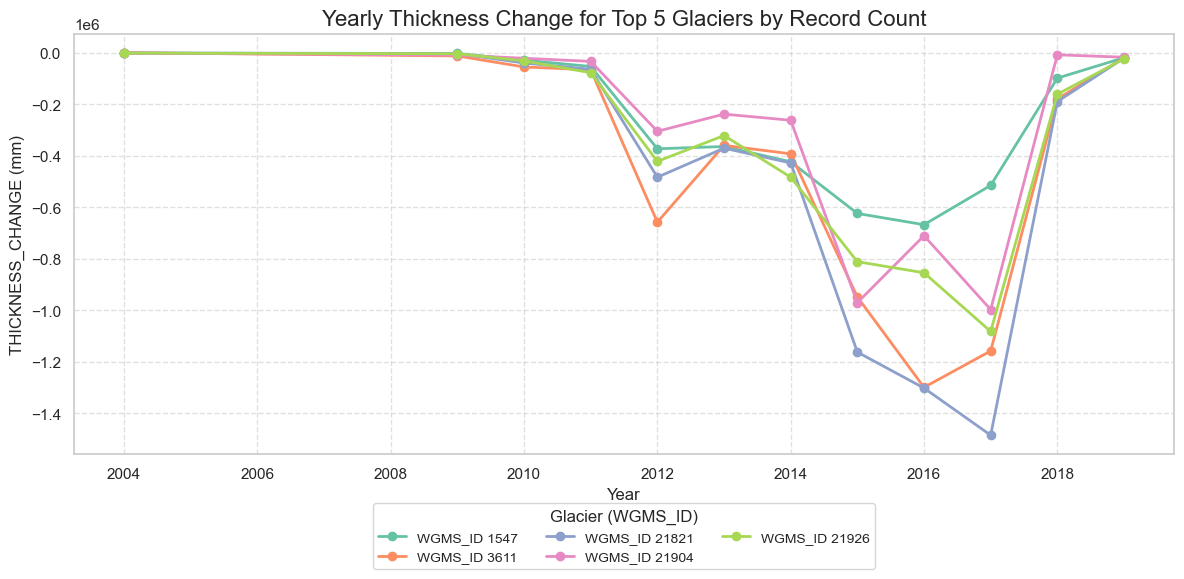

In [14]:
# Use Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 6))

# Colors for Top 5 glaciers
colors = sns.color_palette("Set2", 5)

# Plot each glacier's thickness change
for i, wgms_id in enumerate(gdf_top5_yr_tk_cng['WGMS_ID'].unique()):
    glacier_data = gdf_top5_yr_tk_cng[gdf_top5_yr_tk_cng['WGMS_ID'] == wgms_id]
    plt.plot(glacier_data['CHANGE_YEAR'], glacier_data['THICKNESS_CHANGE'], 
             marker='o', linestyle='-', color=colors[i], label=f'WGMS_ID {wgms_id}', linewidth=2)

plt.title('Yearly Thickness Change for Top 5 Glaciers by Record Count', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('THICKNESS_CHANGE (mm)', fontsize=12)

plt.legend(title='Glacier (WGMS_ID)', loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

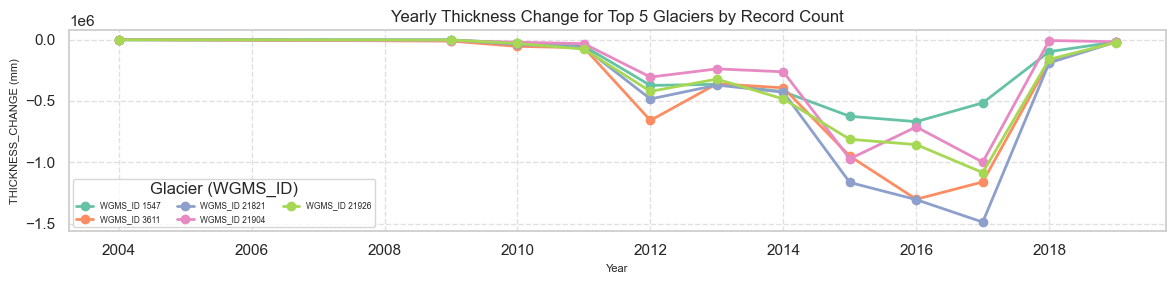

In [15]:
# Use Seaborn
sns.set(style="whitegrid")

plt.figure(figsize=(12, 3))

# Colors for Top 5 glaciers
colors = sns.color_palette("Set2", 5)

# Plot each glacier's thickness change
for i, wgms_id in enumerate(gdf_top5_yr_tk_cng['WGMS_ID'].unique()):
    glacier_data = gdf_top5_yr_tk_cng[gdf_top5_yr_tk_cng['WGMS_ID'] == wgms_id]
    plt.plot(glacier_data['CHANGE_YEAR'], glacier_data['THICKNESS_CHANGE'], 
             marker='o', linestyle='-', color=colors[i], label=f'WGMS_ID {wgms_id}', linewidth=2)

plt.title('Yearly Thickness Change for Top 5 Glaciers by Record Count', fontsize=12)
plt.xlabel('Year', fontsize=8)
plt.ylabel('THICKNESS_CHANGE (mm)', fontsize=8)

plt.legend(title='Glacier (WGMS_ID)', loc='lower left', ncol=3, fontsize=6)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

### Examine the glacier in ALL

In [16]:
# NZ TA
# https://datafinder.stats.govt.nz/layer/111193-territorial-authority-2023-clipped-generalised/

ta = gpd.read_file("data/nz_ta/territorial-authority-2023-clipped-generalised.shp").to_crs(4326)
ta

,TA2023_V1_,TA2023_V_1,TA2023_V_2,LAND_AREA_,AREA_SQ_KM,Shape_Leng,geometry
0,001,Far North District,Far North District,6686.609620,6698.957440,2.167300e+06,"MULTIPOLYGON (((173.48 -35.387, 173.48 -35.387..."
1,002,Whangarei District,Whangarei District,2711.440261,2711.440261,9.264072e+05,"MULTIPOLYGON (((174.7 -35.992, 174.7 -35.992, ..."
2,003,Kaipara District,Kaipara District,3109.089171,3109.089171,9.343111e+05,"MULTIPOLYGON (((174.27 -36.289, 174.27 -36.289..."
3,011,Thames-Coromandel District,Thames-Coromandel District,2207.590078,2207.590078,8.337440e+05,"MULTIPOLYGON (((175.9 -37.221, 175.9 -37.221, ..."
4,012,Hauraki District,Hauraki District,1270.117050,1270.117050,3.112583e+05,"MULTIPOLYGON (((175.53 -37.169, 175.53 -37.169..."
...,...,...,...,...,...,...,...
62,073,Southland District,Southland District,29575.188900,30226.490278,4.022673e+06,"MULTIPOLYGON (((167.5 -47.288, 167.5 -47.288, ..."
63,074,Gore District,Gore District,1253.848352,1253.848352,2.345176e+05,"POLYGON ((169 -45.792, 169 -45.793, 169 -45.79..."
64,075,Invercargill City,Invercargill City,389.917666,389.917666,2.689775e+05,"MULTIPOLYGON (((168.41 -46.649, 168.41 -46.649..."
65,076,Auckland,Auckland,4941.164248,4942.230520,2.894126e+06,"MULTIPOLYGON (((174.78 -36.957, 174.78 -36.957..."


In [17]:
# ta.explore()

In [18]:
# Spatial join depends on ta
gdf_joined = gpd.sjoin(gdf_wgms, ta, how="inner", predicate="within")

In [19]:
gdf_joined.head(5)

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry,index_right,TA2023_V1_,TA2023_V_1,TA2023_V_2,LAND_AREA_,AREA_SQ_KM,Shape_Leng
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32),53,063,Ashburton District,Ashburton District,6181.450937,6189.514871,419614.521033


In [20]:
# Aggregate by ta
gpd_tmp1 = gdf_joined.groupby('TA2023_V_1').agg({
    'THICKNESS_CHANGE': 'sum',
    'WGMS_ID': pd.Series.nunique,
    'geometry': lambda x: MultiPoint(list(x))
}).reset_index()

gdf_tmp2 = gpd.GeoDataFrame(gpd_tmp1, geometry='geometry', crs="EPSG:4326")
gdf_tmp2

,TA2023_V_1,THICKNESS_CHANGE,WGMS_ID,geometry
0,Ashburton District,-8808297.0,300,"MULTIPOINT (170.72 -43.32, 170.72 -43.32, 170...."
1,Hurunui District,-79445.0,1,"MULTIPOINT (172.59 -42.22, 172.59 -42.22, 172...."
2,Mackenzie District,-96239089.0,404,"MULTIPOINT (170.42 -43.5, 170.42 -43.5, 170.42..."
3,Queenstown-Lakes District,-40518983.0,527,"MULTIPOINT (168.19 -44.786, 168.19 -44.786, 16..."
4,Ruapehu District,-2560194.0,10,"MULTIPOINT (175.55 -39.275, 175.55 -39.275, 17..."
5,Selwyn District,-1718533.0,152,"MULTIPOINT (171.19 -43.16, 171.19 -43.16, 171...."
6,Southland District,-11174179.0,295,"MULTIPOINT (168.36 -44.42, 168.36 -44.42, 168...."
7,Taupo District,-919008.0,7,"MULTIPOINT (175.57 -39.26, 175.57 -39.26, 175...."
8,Timaru District,-1995411.0,8,"MULTIPOINT (170.62 -43.48, 170.62 -43.48, 170...."
9,Waitaki District,-17982705.0,128,"MULTIPOINT (169.68 -44.076, 169.68 -44.076, 16..."


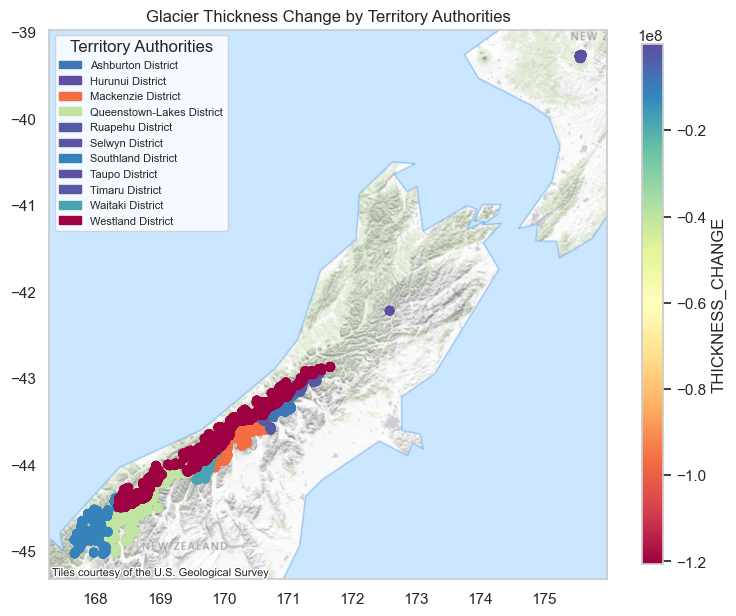

In [21]:
fig, ax = plt.subplots(figsize=(9, 9))
plot = gdf_tmp2.plot(column='THICKNESS_CHANGE', cmap='Spectral', ax=ax)
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)

# Colorbar
cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
cbar.set_label('THICKNESS_CHANGE', size=12)

# Create a custom legend with TA2023_V_1 names and colors
ta_labels = gdf_tmp2['TA2023_V_1'].unique()
# Normalize thickness change values for colors
norm = plt.Normalize(vmin=gdf_tmp2['THICKNESS_CHANGE'].min(), vmax=gdf_tmp2['THICKNESS_CHANGE'].max())
colors = plt.cm.Spectral(norm(gdf_tmp2['THICKNESS_CHANGE']))

# Create legend patches
legend_patches = [Patch(color=color, label=label) for label, color in zip(ta_labels, colors)]

# Add the custom legend to the plot
plt.legend(handles=legend_patches, title='Territory Authorities', loc='upper left', fontsize=8)

plt.grid()
plt.title('Glacier Thickness Change by Territory Authorities')
plt.show()

In [22]:
# gdf_wgms.to_csv("gdf_wgms.csv")

In [23]:
gdf_wgms

,WGMS_ID,CHANGE_YEAR,THICKNESS_CHANGE,NAME,LATITUDE,LONGITUDE,geometry
0,2923,2013,5913.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
1,2923,2018,-14433.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
2,2923,2018,-13184.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
3,2923,2014,-7845.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
4,2923,2017,-7478.0,ADAMS,-43.32,170.720001,POINT (170.72 -43.32)
...,...,...,...,...,...,...,...
45638,1593,2004,-800.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45639,1593,2019,-10840.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45640,1593,2009,-2355.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)
45641,1593,2014,-3145.0,ZORA,-43.75,169.830002,POINT (169.83 -43.75)


In [24]:
gdf_wgms['CHANGE_YEAR'].value_counts(sort=False)

CHANGE_YEAR
2013    3107
2018     940
2014    6162
2017    6998
2015    6584
2016    5848
2004    2758
2019    5516
2009    2853
2012    3764
2010     393
2011     720
Name: count, dtype: int64

In [25]:
# gdf_wgms_2009 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2009]
# len(gdf_wgms_2009)

In [26]:
# gdf_wgms_2016 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2016]
# len(gdf_wgms_2016)

In [27]:
# gdf_wgms_2019 = gdf_wgms[gdf_wgms["CHANGE_YEAR"] == 2019]
# len(gdf_wgms_2019)

In [28]:
# gdf_wgms_2009.to_file("data_cleaned\gdf_wgms_2009.gpkg")
# gdf_wgms_2016.to_file("data_cleaned\gdf_wgms_2016.gpkg")
# gdf_wgms_2019.to_file("data_cleaned\gdf_wgms_2019.gpkg")

In [29]:
# gdf_wgms_2009.to_csv("data_cleaned\gdf_wgms_2009.csv")
# gdf_wgms_2016.to_csv("data_cleaned\gdf_wgms_2016.csv")
# gdf_wgms_2019.to_csv("data_cleaned\gdf_wgms_2019.csv")

In [30]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2009.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2009")
# plt.grid()
# plt.show()

In [31]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2016.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2016")
# plt.grid()
# plt.show()

In [32]:
# fig, ax = plt.subplots(figsize=(9, 9))
# plot = gdf_wgms_2019.plot(column='THICKNESS_CHANGE', cmap='nipy_spectral', legend=False, ax=ax)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# cbar = plt.colorbar(plot.collections[0], ax=ax, shrink=0.75, aspect=25)
# cbar.set_label('THICKNESS_CHANGE', size=12)
# plt.title("Glacier Thickness Change 2019")
# plt.grid()
# plt.show()

# Bird

In [33]:
bird_df = pd.read_csv("data_cleaned/bird_data.csv")

bird_gdf = gpd.GeoDataFrame(
    bird_df, 
    geometry=gpd.points_from_xy(bird_df.LONGITUDE, bird_df.LATITUDE), 
    crs="EPSG:4326"
)[["OBSERVATION DATE", "OBSERVATION COUNT", "geometry"]]

bird_gdf['year'] = bird_gdf["OBSERVATION DATE"].str[:4].astype(int)
bird_gdf.drop('OBSERVATION DATE', axis=1, inplace=True)

In [34]:
bird_gdf = bird_gdf[bird_gdf['year'].isin([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019])]
bird_gdf['year'].value_counts()

year
2019    157
2018    135
2010    110
2009    107
2011     91
2016     77
2017     77
2012     73
2015     61
2014     46
2013     41
Name: count, dtype: int64

In [35]:
bird_gdf

,OBSERVATION COUNT,geometry,year
4,1.0,POINT (172.7 -42.111),2013
158,1.0,POINT (171.52 -42.914),2009
159,1.0,POINT (171.57 -42.928),2010
160,2.0,POINT (171.17 -43.091),2010
161,1.0,POINT (171.52 -42.914),2011
...,...,...,...
5013,2.0,POINT (171.53 -42.896),2014
5014,4.0,POINT (168.02 -44.756),2012
5015,1.0,POINT (168.02 -44.756),2014
5016,3.0,POINT (168.07 -44.731),2014


# Check spatial autocorrelation of bird

In [36]:
# Global Moran for rock wren occurrennce
observation_counts = bird_gdf['OBSERVATION COUNT']

coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
w = DistanceBand(coords, threshold=5000, binary=True)

moran = Moran(observation_counts, w)

print(f"Global Moran's I: {moran.I}")
print(f"p-value: {moran.p_sim}")

Global Moran's I: -0.0015749108455458995
p-value: 0.096


# Analyse annual change

In [37]:
# yearly total observation counts
yearly_counts = bird_gdf.groupby('year')['OBSERVATION COUNT'].sum().reset_index()
yearly_counts.columns = ['Year', 'Total Observation Count']
yearly_counts

,Year,Total Observation Count
0,2009,167.0
1,2010,198.0
2,2011,165.0
3,2012,132.0
4,2013,83.0
5,2014,81.0
6,2015,150.0
7,2016,134.0
8,2017,163.0
9,2018,335.0


In [38]:
# yearly changes and percentage changes
yearly_counts['Change'] = yearly_counts['Total Observation Count'].diff()
yearly_counts['Percentage Change'] = yearly_counts['Change'] / yearly_counts['Total Observation Count'].shift(1) * 100
yearly_counts

,Year,Total Observation Count,Change,Percentage Change
0,2009,167.0,NaN,NaN
1,2010,198.0,31.0,18.562874
2,2011,165.0,-33.0,-16.666667
3,2012,132.0,-33.0,-20.000000
4,2013,83.0,-49.0,-37.121212
5,2014,81.0,-2.0,-2.409639
6,2015,150.0,69.0,85.185185
7,2016,134.0,-16.0,-10.666667
8,2017,163.0,29.0,21.641791
9,2018,335.0,172.0,105.521472


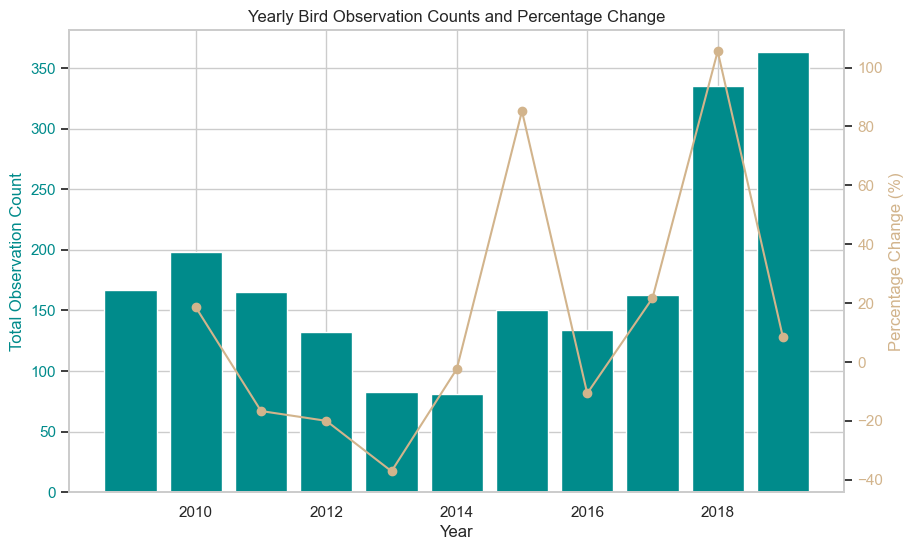

In [39]:
# Compare yearly observation counts vs. changes
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(yearly_counts['Year'], yearly_counts['Total Observation Count'], color='darkcyan', label='Total Observation Count')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Observation Count', color='darkcyan')
ax1.tick_params(axis='y', labelcolor='darkcyan')

ax2 = ax1.twinx()
ax2.plot(yearly_counts['Year'], yearly_counts['Percentage Change'], color='tan', label='Percentage Change', marker='o')
ax2.set_ylabel('Percentage Change (%)', color='tan')
ax2.tick_params(axis='y', labelcolor='tan')

plt.title('Yearly Bird Observation Counts and Percentage Change')
plt.grid(False)
plt.show()

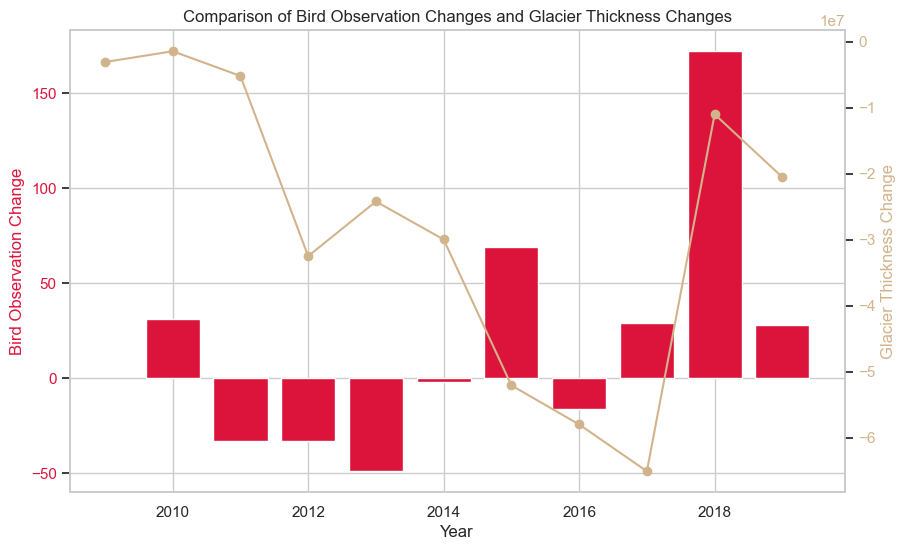

In [40]:
# Compare yearly observation changes vs. glacier thickness changes

yearly_glacier_change = gdf_wgms.groupby('CHANGE_YEAR')['THICKNESS_CHANGE'].sum().reset_index()
yearly_glacier_change.columns = ['Year', 'Total Thickness Change']
comparison_df = pd.merge(yearly_counts, yearly_glacier_change, on='Year', how='inner')

fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.bar(comparison_df['Year'], comparison_df['Change'], color='crimson', label='Bird Observation Change')
ax1.set_xlabel('Year')
ax1.set_ylabel('Bird Observation Change', color='crimson')
ax1.tick_params(axis='y', labelcolor='crimson')

# Asecond y-axis to plot glacier thickness changes
ax2 = ax1.twinx()
ax2.plot(comparison_df['Year'], comparison_df['Total Thickness Change'], color='tan', label='Glacier Thickness Change', marker='o')
ax2.set_ylabel('Glacier Thickness Change', color='tan')
ax2.tick_params(axis='y', labelcolor='tan')

plt.title('Comparison of Bird Observation Changes and Glacier Thickness Changes')
plt.grid(False)
plt.show()


In [41]:
## Check spatial points visually
# fig, ax = plt.subplots(figsize=(10, 10))

# bird_gdf.plot(ax=ax, color='blue', label='Bird Observations', markersize=5)
# gdf_wgms.plot(ax=ax, color='red', label='Glacier Thickness', markersize=5)
# ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
# plt.legend()
# plt.grid()
# plt.show()

# Pair rock wren and glacier based on distance

In [42]:
# Pair rock wren occurrence with nearest glacier
bird_coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
glacier_coords = np.array(list(zip(gdf_wgms.geometry.x, gdf_wgms.geometry.y)))

# Build a KDTree for the glacier points
tree = cKDTree(glacier_coords)

# Query for the nearest glacier for each bird observation
distances, indices = tree.query(bird_coords, k=1)

bird_gdf['Nearest Glacier ID'] = gdf_wgms.iloc[indices]['WGMS_ID'].values
bird_gdf['Nearest Glacier Thickness Change'] = gdf_wgms.iloc[indices]['THICKNESS_CHANGE'].values
bird_gdf['Distance to Glacier'] = distances

bird_gdf.head()

,OBSERVATION COUNT,geometry,year,Nearest Glacier ID,Nearest Glacier Thickness Change,Distance to Glacier
4,1.0,POINT (172.7 -42.111),2013,144044,-9275.0,0.159697
158,1.0,POINT (171.52 -42.914),2009,145908,-5780.0,0.004018
159,1.0,POINT (171.57 -42.928),2010,145907,-13860.0,0.049040
160,2.0,POINT (171.17 -43.091),2010,21932,-11396.0,0.013470
161,1.0,POINT (171.52 -42.914),2011,145908,-5780.0,0.004018


# Global Bivariate Moran's I

In [43]:
# Global BV Moran for rock wren occurrennce and glacier changes

coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
w = DistanceBand(coords, threshold=5000, binary=True)

observation_change = bird_gdf['OBSERVATION COUNT']
thickness_change = bird_gdf['Nearest Glacier Thickness Change']

moran_bv = Moran_BV(observation_change, thickness_change, w)

print(f"Bivariate Moran's I: {moran_bv.I}")
print(f"p-value: {moran_bv.p_sim}")


Bivariate Moran's I: -0.0001247611840395598
p-value: 0.176


# Local Bivariate Moran's I

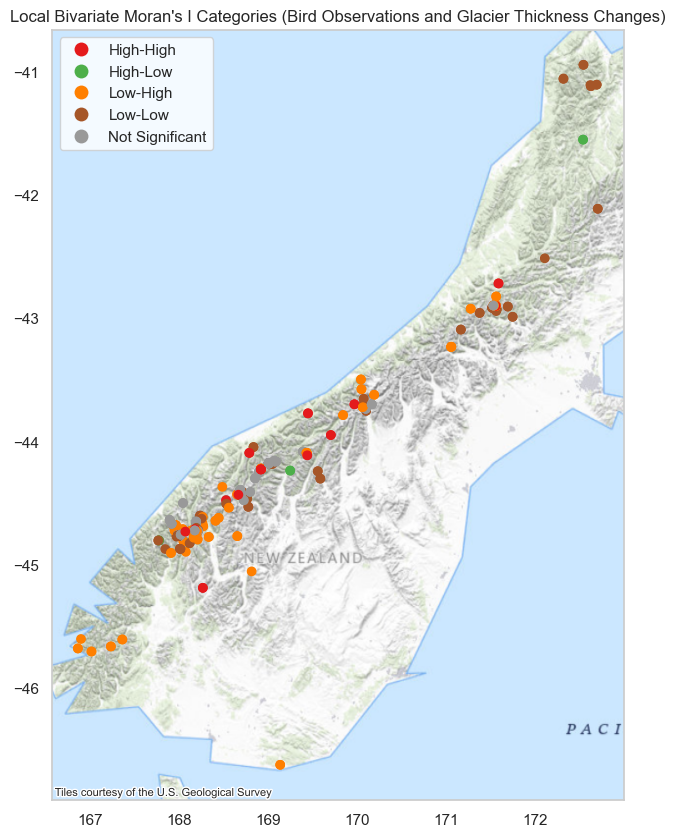

In [44]:
# Local BV Moran for rock wren occurrennce and glacier 

coords = np.array(list(zip(bird_gdf.geometry.x, bird_gdf.geometry.y)))
w = DistanceBand(coords, threshold=5000, binary=True)

observation_change = bird_gdf['OBSERVATION COUNT']
thickness_change = bird_gdf['Nearest Glacier Thickness Change']

local_bv = Moran_Local_BV(observation_change, thickness_change, w)

bird_gdf['Local Bivariate Moran'] = local_bv.Is
bird_gdf['p-value'] = local_bv.p_sim

observation_z = (observation_change - observation_change.mean()) / observation_change.std()
thickness_z = (thickness_change - thickness_change.mean()) / thickness_change.std()

significance_level = 0.05

# Define 5 classes
def categorize(local_moran, p_val, obs_z, thick_z):
    if p_val > significance_level:
        return 'Not Significant'
    if obs_z > 0 and thick_z > 0:
        return 'High-High'
    elif obs_z < 0 and thick_z < 0:
        return 'Low-Low'
    elif obs_z > 0 and thick_z < 0:
        return 'High-Low'
    elif obs_z < 0 and thick_z > 0:
        return 'Low-High'
    else:
        return 'Not Significant'

# Classification
bird_gdf['LISA_Category'] = [
    categorize(local_moran, p_val, obs_z, thick_z) 
    for local_moran, p_val, obs_z, thick_z in zip(local_bv.Is, local_bv.p_sim, observation_z, thickness_z)
]

# Plot results
fig, ax = plt.subplots(figsize=(10, 10))
bird_gdf.plot(column='LISA_Category', categorical=True, legend=True,
              cmap='Set1', ax=ax)
plt.title("Local Bivariate Moran's I Categories (Bird Observations and Glacier Thickness Changes)")
ctx.add_basemap(ax, crs="EPSG:4326", source=ctx.providers.USGS.USTopo)
plt.grid()
plt.show()
